In [2]:
%pylab inline
import networkx as nx
from networkx.algorithms import bipartite
import pandas as pd
import gzip
import pickle
import random
import seaborn 


Populating the interactive namespace from numpy and matplotlib


We use organisms that have >80% coverage and more than 1000 proteins in the proteome. 
These are saved from another notebook titled **parse_pfam_index**. 
Some relevant stats are given there.

In [3]:
organisms = pickle.load(open('list.pkl', 'rb'))
print ('there are {} organisms in the set'.format(len(organisms)))

there are 2266 organisms in the set


These are the c-d-GMP **binding** domains. 
There are many more that are c-d-GMP **associated**, but these are those with experimental evidence (says Melene)
  
  * PilZ  [PF07238](http://pfam.xfam.org/family/PF07238)
  * GGDEF [PF00990](http://pfam.xfam.org/family/ggdef)
  * GIL [PF10995](http://pfam.xfam.org/family/PF10995)
  * EAL [PF00563](http://pfam.xfam.org/family/PF00563)
  * HD_5, PF13487
  * FleQ, PF06490
  * MshEN, PF05157


  * PilZ_2 [PF16823](http://pfam.xfam.org/family/PF16823)

In [4]:
relevant_domains = {
    'PF07238':'PilZ', 
    'PF00990':'GGDEF', 
    'PF00563':'EAL',
    'PF10995':'GIL',
    'PF13487':'HD_5',
    'PF06490':'FleQ',
    'PF05157':'MshEN'
}

In [131]:
# alternatively, load data from picke

data = pickle.load(open('data.pkl', 'rb'))
data.describe()

,nproteins,ndomains,ncomps,majorcomp,PilZ_k,PilZ_c,PilZ_n,PilZ_bc,PilZ_ec,GGDEF_k,...,MshEN_n,MshEN_bc,MshEN_ec,FleQ_k,FleQ_c,FleQ_n,FleQ_bc,FleQ_ec,GIL_k,GIL_n
count,2266.000000,2266.000000,2266.000000,2266.000000,1229.000000,856.000000,1229.000000,341.000000,3.410000e+02,1751.000000,...,1113.000000,149.000000,1.490000e+02,203.000000,202.000000,203.00000,192.0,192.000000,74.0,74.0
mean,2816.634157,1818.064431,1165.292586,74.719329,1.167616,0.106724,16.133442,0.421568,3.518067e-01,8.960594,...,11.803235,0.362275,3.306390e-01,1.940887,0.950495,109.26601,0.0,0.015009,0.0,1.0
std,1141.722047,410.401002,260.825043,52.311773,1.181932,0.266607,41.898455,0.402929,2.946933e-01,6.709579,...,39.599568,0.469166,3.247544e-01,0.256506,0.217459,40.62675,0.0,0.024782,0.0,0.0
min,823.000000,697.000000,463.000000,8.000000,0.000000,0.000000,1.000000,0.000000,1.951779e-12,0.000000,...,1.000000,0.000000,6.331922e-07,0.000000,0.000000,1.00000,0.0,0.003978,0.0,1.0
25%,1914.500000,1499.250000,960.000000,39.000000,0.000000,0.000000,1.000000,0.022989,4.167184e-02,3.000000,...,2.000000,0.000000,1.494365e-02,2.000000,1.000000,78.00000,0.0,0.009430,0.0,1.0
50%,2702.000000,1840.000000,1168.000000,57.000000,1.000000,0.000000,2.000000,0.285714,3.424853e-01,8.000000,...,2.000000,0.000000,1.436266e-01,2.000000,1.000000,111.00000,0.0,0.011736,0.0,1.0
75%,3513.500000,2127.750000,1373.000000,96.000000,2.000000,0.000000,4.000000,0.833333,6.532815e-01,13.000000,...,2.000000,1.000000,7.071068e-01,2.000000,1.000000,138.00000,0.0,0.015391,0.0,1.0
max,12055.000000,3204.000000,2010.000000,341.000000,10.000000,1.000000,335.000000,1.000000,7.071068e-01,36.000000,...,335.000000,1.000000,7.071068e-01,2.000000,1.000000,224.00000,0.0,0.342672,0.0,1.0


### Testing for normality

Here we use the [Shaphiro-Wilk test](https://en.wikipedia.org/wiki/Shapiro%E2%80%93Wilk_test) to look at the distribution of each feature we measured to see if they are normally distributed or not. Those with **small p values** are not likely to be normally distributed. 

In [82]:
from scipy.stats import shapiro
for feature in data.columns :
    if '_' in feature :
        x = data[feature].dropna()
        
        if len(x)>10 and std(x) >0.01: 
            x -= mean(x)
            x /= std(x)    
            pval = shapiro (x )[1]
            print ('{} : {}'.format(feature, pval))
    

HD_5 : 0.0
PilZ_k : 4.297001160585159e-36
PilZ_c : 4.203895392974451e-45
PilZ_n : 0.0
PilZ_bc : 2.1417665443073871e-19
PilZ_ec : 1.965242194932479e-20
GGDEF_k : 1.7985117751212572e-25
GGDEF_c : 3.9950443990486123e-35
GGDEF_n : 2.7520045557270316e-30
GGDEF_bc : 3.8799838516473054e-39
GGDEF_ec : 1.3469335326049693e-28
EAL_k : 1.7844880844533574e-28
EAL_c : 1.2059692599638752e-26
EAL_n : 7.721360092133315e-29
EAL_bc : 0.0
EAL_ec : 1.1740840585278546e-29
HD_5_k : 2.820601751083391e-31
HD_5_c : 1.6776915453060807e-32
HD_5_n : 2.4983572498704406e-28
HD_5_bc : 2.475864543021548e-34
HD_5_ec : 3.902933624969677e-27
MshEN_k : 0.0
MshEN_c : 0.0
MshEN_n : 0.0
MshEN_bc : 1.417749188735467e-17
MshEN_ec : 1.3538258886072307e-15
FleQ_k : 4.063280292867039e-28
FleQ_c : 2.9086845689831618e-28
FleQ_n : 0.9550727009773254
FleQ_ec : 4.385525446714453e-28


(array([   9.,    0.,    0.,  955.,    0.,    0.,  139.,    0.,    0.,   10.]),
 array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
 <a list of 10 Patch objects>)

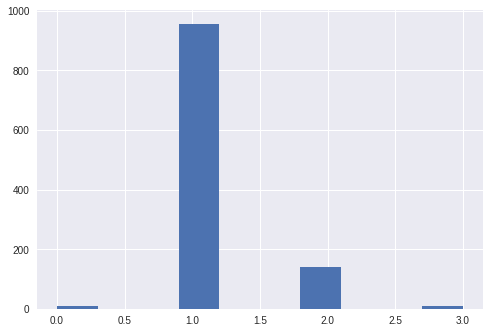

In [86]:
x=  data['MshEN_k'].dropna()
hist(x)
#len(x)

In [96]:
data.as_matrix().shape

(2266, 43)

In [97]:
import numpy as np
from sklearn.cluster import KMeans

def kmeans_missing(X, n_clusters, max_iter=10):
    """Perform K-Means clustering on data with missing values.

    Args:
      X: An [n_samples, n_features] array of data to cluster.
      n_clusters: Number of clusters to form.
      max_iter: Maximum number of EM iterations to perform.

    Returns:
      labels: An [n_samples] vector of integer labels.
      centroids: An [n_clusters, n_features] array of cluster centroids.
      X_hat: Copy of X with the missing values filled in.
    """

    # Initialize missing values to their column means
    missing = ~np.isfinite(X)
    mu = np.nanmean(X, 0, keepdims=1)
    X_hat = np.where(missing, mu, X)

    for i in xrange(max_iter):
        if i > 0:
            # initialize KMeans with the previous set of centroids. this is much
            # faster and makes it easier to check convergence (since labels
            # won't be permuted on every iteration), but might be more prone to
            # getting stuck in local minima.
            cls = KMeans(n_clusters, init=prev_centroids)
        else:
            # do multiple random initializations in parallel
            cls = KMeans(n_clusters, n_jobs=-1)

        # perform clustering on the filled-in data
        labels = cls.fit_predict(X_hat)
        centroids = cls.cluster_centers_

        # fill in the missing values based on their cluster centroids
        X_hat[missing] = centroids[labels][missing]

        # when the labels have stopped changing then we have converged
        if i > 0 and np.all(labels == prev_labels):
            break

        prev_labels = labels
        prev_centroids = cls.cluster_centers_

    return labels, centroids, X_hat


In [170]:
for feature in data.columns : 
    print('{}:{}'.format(feature, sum(data[feature].isnull())))

          

nproteins:0
ndomains:0
ncomps:0
majorcomp:0
PilZ:0
GGDEF:0
EAL:0
GIL:0
HD_5:0
FleQ:0
MshEN:0
PilZ_k:1037
PilZ_c:1410
PilZ_n:1037
PilZ_bc:1925
PilZ_ec:1925
GGDEF_k:515
GGDEF_c:632
GGDEF_n:515
GGDEF_bc:732
GGDEF_ec:732
EAL_k:639
EAL_c:763
EAL_n:639
EAL_bc:931
EAL_ec:931
HD_5_k:1328
HD_5_c:1589
HD_5_n:1328
HD_5_bc:1888
HD_5_ec:1888
MshEN_k:1153
MshEN_c:1162
MshEN_n:1153
MshEN_bc:2117
MshEN_ec:2117
FleQ_k:2063
FleQ_c:2064
FleQ_n:2063
FleQ_bc:2074
FleQ_ec:2074
GIL_k:2192
GIL_n:2192


In [168]:
b=data['MshEN_k']
sum(b.isnull())


1153

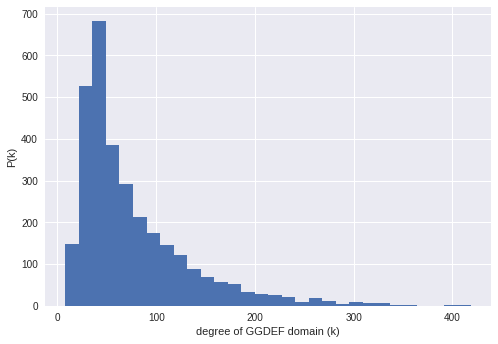

In [25]:

b=a['majorcomp']


# [make a dataframe called df]
b.hist(  bins = 30)
xlabel('degree of GGDEF domain (k)')
ylabel('P(k)')



In [15]:
a.describe()


,nproteins,ndomains,ncomps,majorcomp,PilZ_k,PilZ_n,GGDEF_k,GGDEF_n,EAL_k,EAL_n
count,100.000000,100.00000,100.000000,100.000000,34.000000,34.000000,63.000000,63.000000,55.000000,55.000000
mean,2601.730000,1707.40000,1098.800000,64.160000,0.882353,9.764706,7.380952,66.365079,5.945455,74.290909
std,1163.679274,428.05154,268.783943,50.352639,1.249599,24.046746,6.284719,63.777916,4.855002,64.266423
min,875.000000,769.00000,540.000000,13.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
25%,1588.250000,1330.75000,869.750000,34.000000,0.000000,1.000000,2.000000,5.500000,2.000000,39.500000
50%,2405.000000,1743.00000,1114.500000,48.000000,1.000000,2.000000,7.000000,53.000000,5.000000,58.000000
75%,3254.000000,2087.75000,1350.500000,72.250000,1.000000,2.000000,11.000000,96.000000,8.000000,104.500000
max,5892.000000,2534.00000,1685.000000,280.000000,6.000000,109.000000,25.000000,280.000000,23.000000,280.000000


In [118]:
g.nodes()[0]
g['C7RIB6']

{'PF00308': {'bitscore': 279.0, 'evalue': 4.3e-80},
 'PF08299': {'bitscore': 106.0, 'evalue': 1.1e-27},
 'PF11638': {'bitscore': 64.1, 'evalue': 1.1e-14}}